In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import json


file_name = "labeled_images.h5"

base_dir = "./"+file_name

with open("labaled_data.json", "r") as outfile:
    pointcloud_data = json.load(outfile)

classes = set()
for i in pointcloud_data:
    classes.add(pointcloud_data.get(i)[1])
classes = list(classes)


In [2]:
#split data into training and validation if neccessary
SPLIT_RATIO = 0.8
with h5py.File(file_name, "r") as file:
    c = list(zip(list(file['images']),list(file['labels'])))
    sz = len(c)
    cut = int(sz*SPLIT_RATIO)
    random.shuffle(c)

    training=c[:cut]
    testing=c[cut:]
    
    training_data=[]
    training_labels=[]
    testing_data=[]
    testing_labels=[]

    for a in training:
        training_data.append(a[0])
        training_labels.append(a[1])

    for a in testing:
        testing_data.append(a[0])
        testing_labels.append(a[1])

training_x=np.array(training_data)
training_labels=np.array(training_labels)
training_data = tf.data.Dataset.from_tensor_slices((training_x, training_labels))
testing_x=np.array(testing_data)
testing_labels=np.array(testing_labels)
testing_data = tf.data.Dataset.from_tensor_slices((testing_x, testing_labels))
display(training_data, testing_data)

<TensorSliceDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

<TensorSliceDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

In [3]:

IMAGE_SIZE = 224

BATCH_SIZE = 4

input_shape = training_x.shape[1:]

train_dataset = training_data.batch(BATCH_SIZE)
# display(input_shape)
inputs = keras.Input(shape=input_shape)


x = layers.Rescaling(1.0 / 255)(inputs)  # Rescale inputs
base_model = keras.applications.ResNet50V2(  # Add the rest of the model
    weights=None, input_shape=input_shape, classes=2
)(x)


model = keras.Model(inputs, base_model)
model.compile(optimizer=keras.optimizers.experimental.RMSprop(learning_rate=0.001), 
              loss="sparse_categorical_crossentropy", 
              metrics=[keras.metrics.SparseCategoricalAccuracy()])


# data_generator.fit(training_data)

# display(training_data.shape)
# display(training_labels.shape)

# for image_batch, label_batch in train_generator:
#     break

In [4]:
try:
    model.load_weights("./Saved_resnet_weights")
except:
    print("no weights")
history = model.fit(train_dataset, epochs=100)

model.save_weights("./Saved_resnet_weights")

Epoch 1/100
106/106 [==============================] - 22s 47ms/step - loss: 0.7904 - sparse_categorical_accuracy: 0.4962
Epoch 2/100
106/106 [==============================] - 4s 41ms/step - loss: 0.7470 - sparse_categorical_accuracy: 0.4962
Epoch 3/100
106/106 [==============================] - 5s 43ms/step - loss: 0.7350 - sparse_categorical_accuracy: 0.4943
Epoch 4/100
106/106 [==============================] - 4s 42ms/step - loss: 0.7368 - sparse_categorical_accuracy: 0.5095
Epoch 5/100
106/106 [==============================] - 4s 40ms/step - loss: 0.7285 - sparse_categorical_accuracy: 0.5114
Epoch 6/100
106/106 [==============================] - 4s 42ms/step - loss: 0.7280 - sparse_categorical_accuracy: 0.5000
Epoch 7/100
106/106 [==============================] - 4s 41ms/step - loss: 0.7272 - sparse_categorical_accuracy: 0.5247
Epoch 8/100
106/106 [==============================] - 4s 42ms/step - loss: 0.7128 - sparse_categorical_accuracy: 0.5133
Epoch 9/100
106/106 [==========

106/106 [==============================] - 4s 41ms/step - loss: 0.2335 - sparse_categorical_accuracy: 0.9030
Epoch 69/100
106/106 [==============================] - 4s 41ms/step - loss: 0.2232 - sparse_categorical_accuracy: 0.9087
Epoch 70/100
106/106 [==============================] - 5s 46ms/step - loss: 0.1916 - sparse_categorical_accuracy: 0.9240
Epoch 71/100
106/106 [==============================] - 4s 41ms/step - loss: 0.2366 - sparse_categorical_accuracy: 0.9011
Epoch 72/100
106/106 [==============================] - 4s 41ms/step - loss: 0.1936 - sparse_categorical_accuracy: 0.9259
Epoch 73/100
106/106 [==============================] - 4s 40ms/step - loss: 0.1777 - sparse_categorical_accuracy: 0.9392
Epoch 74/100
106/106 [==============================] - 4s 41ms/step - loss: 0.1519 - sparse_categorical_accuracy: 0.9468
Epoch 75/100
106/106 [==============================] - 4s 40ms/step - loss: 0.1366 - sparse_categorical_accuracy: 0.9449
Epoch 76/100
106/106 [===============

In [5]:
results = model.evaluate(testing_x, testing_labels, batch_size=16)
print("test loss, test acc:", results)

9/9 [==============================] - 6s 251ms/step - loss: 2.8573 - sparse_categorical_accuracy: 0.6364
test loss, test acc: [2.8573312759399414, 0.6363636255264282]


1/1 [==============================] - 0s 18ms/step
classes:closed_mouth, open_mouth
predictions: [[7.8783705e-05 9.9992120e-01]]
actual: [1]


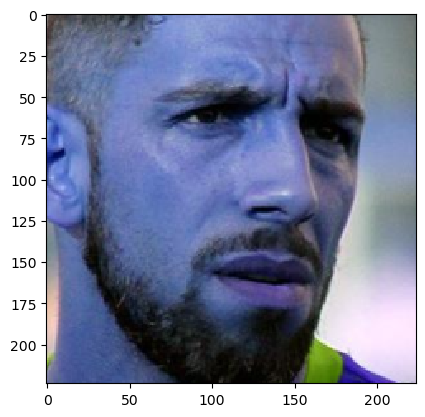

In [51]:
from matplotlib import pyplot as plt
index_start = 32
index_end = index_start+1
predictions = model.predict(testing_x[index_start:index_end])
print("classes:" +classes[0] +", "+ classes[1] )
# print("predictions shape:", predictions.shape)
print("predictions:", predictions)
print("actual:", testing_labels[index_start:index_end])

plt.imshow(testing_x[index_start], interpolation='nearest')
plt.show()

In [6]:
# print(train_generator.class_indices)

# IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')

# base_model.trainable = False

# model = tf.keras.Sequential([
#     base_model,  # 1
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),  # 2
#     tf.keras.layers.Dropout(0.2),  # 3
#     tf.keras.layers.GlobalAveragePooling2D(),  # 4
#     tf.keras.layers.Dense(3, activation='softmax')  # 5
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(),  # 1
#               loss='categorical_crossentropy',  # 2
#               metrics=['accuracy'])  # 3

# model.summary()

# print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

# epochs = 10

# history = model.fit(training_data,
#             epochs=epochs,
#             validation_data=testing_data)

# base_model.trainable = True

# fine_tune_at = 100

# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False
    
# model.compile(loss='categorical_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(1e-5),
#               metrics=['accuracy'])

# model.summary()

# history_fine = model.fit(training_data,
#                     epochs=epochs,
#                     validation_data=testing_data)

# saved_model_dir = 'save/fine_tuning.h5'
# model.save(saved_model_dir)